**Auteur** : Viktoriya Zeruk<br>
**Date dernière version** : 18/05/2022<br>

---


<div style="display: flex; background: rgb(75,0,130);
background: linear-gradient(90deg, rgba(75,0,130,1) 47%, rgba(216,191,216,1) 89%, rgba(230,230,250,1) 100%);">
<h2 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Project 4 : Segmentez des clients d'un site e-commerce
 </br>  | Notebook 3 :  RFM  | <br></h2> </div>    


<div style="display: flex; background: rgb(75,0,130);
background: linear-gradient(90deg, rgba(75,0,130,1) 47%, rgba(216,191,216,1) 89%, rgba(230,230,250,1) 100%);">
<h4 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center"> _______________________________________________________________________________________________</h4> 
</div>    

###  Marketing Analytics - Segmentation client RFM avec K Means

En matière de marketing, si vous essayez de parler à tout le monde, vous aurez du mal à joindre qui que ce soit. Les messages vagues et génériques sont beaucoup moins susceptibles de trouver un écho auprès du public qu'une communication directe spécifique - c'est pourquoi le ciblage en marketing est si important. Les spécialistes du marketing intelligents comprennent l'importance de "connaître le client". Au lieu de simplement se concentrer sur la génération de plus de clics, les spécialistes du marketing doivent suivre le changement de paradigme de l'augmentation des CTR (taux de clics) vers la rétention, la fidélité et l'établissement de relations avec les clients.

Au lieu d'analyser l'ensemble de la clientèle dans son ensemble, il est préférable de les segmenter en groupes homogènes, de comprendre les caractéristiques/comportements de chaque groupe et de les engager avec des campagnes ciblées pertinentes.

##### L'analyse RFM est l'une des méthodes de segmentation les plus populaires, les plus faciles à utiliser et les plus efficaces qui permettent aux spécialistes du marketing d'analyser le comportement des clients.

RFM signifie récence, fréquence et valeur monétaire, chacune correspondant à un trait clé du client. Ces mesures RFM sont des indicateurs importants du comportement d'un client, car la fréquence et la valeur monétaire affectent la valeur à vie d'un client, et la récence affecte la rétention, une mesure de l'engagement.

Les entreprises qui n'ont pas l'aspect monétaire, comme l'audience, le lectorat ou les produits axés sur le surf, pourraient utiliser des paramètres d'engagement au lieu de paramètres monétaires. Cela se traduit par l'utilisation de RFE (récence, fréquence, engagement) - une variante de RFM. De plus, ce paramètre d'engagement pourrait être défini comme une valeur composite basée sur des mesures telles que le taux de rebond, la durée de la visite, le nombre de pages visitées, le temps passé par page, etc.

Les caractéristiques RFM des clients illustrent ces caractéristiques :

1. Plus leurs achats sont récents, plus ils sont sensibles aux promotions.
2. Plus ils achètent fréquemment, plus ils sont engagés et satisfaits.
3. Plus la valeur monétaire aide à différencier les grands dépensiers des petits dépensiers.

Nous voulons également être en mesure de segmenter nos données en fonction de leur comportement.

In [15]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import re
from pandas.plotting import scatter_matrix
import time, warnings
import datetime as dt
import plotly.offline as py
import plotly.graph_objs as go
import os

In [16]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [17]:
# Reading all the files
raw_path = 'data/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')
olist_product_translation = pd.read_csv(raw_path + 'product_category_name_translation.csv')

In [18]:
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments, 
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments', 
            'olist_order_reviews', 'olist_products', 'olist_sellers']

In [19]:
# Creating a DataFrame with useful information about all datasets
df_info = pd.DataFrame({})
df_info['dataset'] = names
df_info['n_rows'] = [df.shape[0] for df in datasets]
df_info['n_cols'] = [df.shape[1] for df in datasets]
df_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
df_info['null_columns_qty'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
df_info['null_columns_names'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

df_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,null_columns_qty,null_columns_names
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


Missing values

In [20]:
olist_orders = olist_orders.drop(columns=['order_approved_at' , 'order_delivered_customer_date', 'order_delivered_carrier_date'])
olist_products = olist_products.drop(columns=["product_weight_g","product_name_lenght", "product_description_lenght", "product_photos_qty", "product_height_cm", "product_width_cm", "product_length_cm"])
olist_order_reviews = olist_order_reviews.drop(columns=['review_comment_title', 'review_comment_message'])

In [21]:
olist_products = olist_products.merge(olist_product_translation, on='product_category_name')
olist_products = olist_products.rename(columns={'product_category_name_english':'product_category_name', 'product_category_name':'product_category_name_old'})
olist_products = olist_products.drop(columns=['product_category_name_old'])
olist_products.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumery
2,0d009643171aee696f4733340bc2fdd0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,perfumery


Creation Master Dataframe

In [22]:
df1 = olist_order_items.merge(olist_order_payments, on='order_id')
print(df1.shape)
df2 = df1.merge(olist_products, on='product_id')
print(df2.shape)
df3 = df2.merge(olist_sellers, on='seller_id')
print(df3.shape)
df4 = df3.merge(olist_order_reviews, on='order_id')
print(df4.shape)
df5 = df4.merge(olist_orders, on='order_id')
print(df5.shape)
#df6 = df5.merge(olist_product_translation, on='product_category_name')
#print(df6.shape)
Olist_db = df5.merge(olist_customer, on='customer_id')
print(Olist_db.shape)

(117601, 11)
(115878, 12)
(115878, 15)
(115609, 19)
(115609, 23)
(115609, 27)


In [23]:
Olist_db.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'product_category_name', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')

In [24]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp', 'order_estimated_delivery_date']
for col in date_columns:
    Olist_db[col] = pd.to_datetime(Olist_db[col], format='%Y-%m-%d %H:%M:%S')

In [25]:
# cleaning up name columns, and engineering new/essential columns
Olist_db['customer_city'] = Olist_db['customer_city'].str.title()
Olist_db['seller_city'] = Olist_db['seller_city'].str.title()
Olist_db['product_category_name'] = Olist_db['product_category_name'].str.title()
Olist_db['payment_type'] = Olist_db['payment_type'].str.replace('_', ' ').str.title()
Olist_db['product_category_name'] = Olist_db['product_category_name'].str.replace('_', ' ')
Olist_db['review_response_time'] = (Olist_db['review_answer_timestamp'] - Olist_db['review_creation_date']).dt.days
#Olist_db['delivery_against_estimated'] = (Olist_db['order_estimated_delivery_date'] - Olist_db['order_delivered_customer_date']).dt.days
#Olist_db['product_size_cm'] = Olist_db['product_length_cm'] * Olist_db['product_height_cm'] * Olist_db['product_width_cm']
Olist_db['order_purchase_year'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.year)
Olist_db['order_purchase_month'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.month)
Olist_db['order_purchase_dayofweek'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.dayofweek)
Olist_db['order_purchase_hour'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.hour)
Olist_db['order_purchase_day'] = Olist_db['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
Olist_db['order_purchase_mon'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

In [26]:
Olist_db.to_csv('Olist_Master.csv', index=False)

In [27]:
Olist_db

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,...,customer_zip_code_prefix,customer_city,customer_state,review_response_time,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,Credit Card,2,...,28013,Campos Dos Goytacazes,RJ,1,2017,9,2,8,Wed,Sep
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.90,17.96,1,Boleto,1,...,75800,Jatai,GO,3,2017,6,2,11,Wed,Jun
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.90,18.33,1,Credit Card,2,...,30720,Belo Horizonte,MG,1,2018,5,4,10,Fri,May
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.90,16.17,1,Credit Card,3,...,83070,Sao Jose Dos Pinhais,PR,3,2017,8,1,18,Tue,Aug
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.90,13.29,1,Credit Card,4,...,36400,Conselheiro Lafaiete,MG,3,2017,8,3,21,Thu,Aug
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,fd607d0a02cb276bc764a15f80f0423f,2,02ad78835ec3f72e750d1dfa6a7e11b3,2a73cba571d90c694b7caca072ccf6ce,2018-08-02 02:24:15,171.39,19.35,1,Boleto,1,...,41820,Salvador,BA,2,2018,7,3,9,Thu,Jul
115605,fdaf98feac227eb978d8f33f36e0231d,1,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,2017-04-27 05:10:28,119.90,16.14,1,Boleto,1,...,22793,Rio De Janeiro,RJ,1,2017,4,2,10,Wed,Apr
115606,fe68b52db13993f58175fa589125d345,1,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.00,16.21,1,Boleto,1,...,13485,Limeira,SP,1,2017,8,4,10,Fri,Aug
115607,ff701a7c869ad21de22a6994237c8a00,1,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,1,Credit Card,1,...,12280,Cacapava,SP,3,2018,4,3,19,Thu,Apr


In [28]:
features = ['order_id', 'order_status', 'order_purchase_timestamp',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state']
Olist_db = Olist_db[features]
Olist_db.shape

(115609, 8)

In [29]:
df = Olist_db.copy()
Olist_db['order_purchase_date'] = Olist_db.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))

C:\Users\victo\AppData\Local\Temp\ipykernel_21380\2965964461.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
Olist_db = Olist_db.drop_duplicates()

In [31]:
cond = Olist_db["order_status"] == "delivered"
Olist_db = Olist_db.loc[cond]

In [32]:
Olist_db.head()

,order_id,order_status,order_purchase_timestamp,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_date
0,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,72.19,871766c5855e863f6eccc05f988b23cb,28013,Campos Dos Goytacazes,RJ,2017-09-13 08:59:02
1,130898c0987d1801452a8ed92a670612,delivered,2017-06-28 11:52:20,73.86,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,Jatai,GO,2017-06-28 11:52:20
2,532ed5e14e24ae1f0d735b91524b98b9,delivered,2018-05-18 10:25:53,83.23,3419052c8c6b45daf79c1e426f9e9bcb,30720,Belo Horizonte,MG,2018-05-18 10:25:53
3,6f8c31653edb8c83e1a739408b5ff750,delivered,2017-08-01 18:38:42,75.07,e7c828d22c0682c1565252deefbe334d,83070,Sao Jose Dos Pinhais,PR,2017-08-01 18:38:42
4,7d19f4ef4d04461989632411b7e588b9,delivered,2017-08-10 21:48:40,72.19,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,Conselheiro Lafaiete,MG,2017-08-10 21:48:40


## Clustering
La fonction ci-dessous effectue la création d'un clustering hiérarchique défini par les règles suivantes :

#### Segment:

1. Inactif : Client qui n'a effectué aucun achat ou dont le dernier achat a été supérieur à trois fois la période définie en paramètre.

2. Froid : dernier achat a été supérieur à deux fois la période et inférieur à trois fois la période.

3. Chaud : dernier achat était supérieur à la période et inférieur au double de la période.

4. Actif : dernier achat est inférieur à la période.

#### Sous-segment :

1. inactif : Client qui n'a effectué aucun achat ou dont le dernier achat a été supérieur à trois fois la période définie en paramètre.

2. cold_high_payment_value : client dont le segment est égal à cold et dont les achats sont supérieurs ou égaux à la médiane de tous les achats.

3. cold_low_payment_value : client dont le segment est égal à cold et dont les achats sont inférieurs à la médiane de tous les achats.

4. hot_high_payment_value : client dont le segment est égal à hot et dont les achats sont supérieurs ou égaux à la médiane de tous les achats.

5. hot_low_payment_value : client dont le segment est égal à hot et dont les achats sont inférieurs à la médiane de tous les achats.

6. active_high_payment_value : le segment de clientèle est égal à actif et a des achats supérieurs ou égaux à la médiane de tous les achats.

7. active_low_payment_value : le segment de clientèle est égal à actif et a moins que les achats médians de tous les achats.


#### Nouveau client

1. new_customer : Clients dont le premier achat est inférieur au double de la période.

2. période : nombre de jours

In [33]:
def clustering_customers(df, date_max, date_min=False, group_range_days=False):
    df = df.copy()

    if(date_min == False):
        cond_f = df["order_purchase_date"] <= pd.to_datetime(date_max)
    else:
        cond_1 = df["order_purchase_date"] <= pd.to_datetime(date_max)
        cond_2 = df["order_purchase_date"] >= pd.to_datetime(date_min)
        cond_f = cond_1 & cond_2

    df = df.loc[cond_f]

    df["today"] = df["order_purchase_date"].max()

    df["today"] = df["today"].dt.date
    df["today"] = pd.to_datetime(df["today"], format="%Y-%m-%d")

    df["order_purchase_days_since"] = df["today"]  - df["order_purchase_date"]
    df["order_purchase_days_since"] = df["order_purchase_days_since"].astype(str)
    df["order_purchase_days_since"] = df["order_purchase_days_since"].str.replace(r'\s+days.*', '', regex=True)
    df["order_purchase_days_since"] = df["order_purchase_days_since"].astype(int)
    df["order_purchase_year"] = df["order_purchase_date"].dt.year

    agg_group = {
        "order_purchase_days_since": ["min", "max", "count"],
        "payment_value": ["sum","mean"]
    }

    df_group = df.groupby(["customer_unique_id"]).agg(agg_group).reset_index()

    df_group.columns = [' '.join(col).strip() for col in df_group.columns.values]

    columns_rename = {
        "order_purchase_days_since min": "first_order_purchase",
        "order_purchase_days_since max": "last_order_purchase",
        "order_purchase_days_since count": "order_purchase_qty",
        "payment_value mean": "payment_value_mean",
        "payment_value sum": "payment_value_sum"
    }

    
    df_group.rename(columns_rename, axis=1, inplace=True)

    median_payment = df_group["payment_value_mean"].median()

    if(group_range_days == False):
        major_group = 4
        range_days = str(df["order_purchase_date"].max() - df["order_purchase_date"].min()) 
        group_range_days = int(re.sub(r'\s+days.*', '', range_days))/major_group

    cond_payment_zero = df_group['payment_value_mean'] == 0.0

    cond_inactive_1 = df_group['last_order_purchase'] > group_range_days*3
    cond_inactive = cond_inactive_1 | cond_payment_zero

    cond_cold_1 = df_group['last_order_purchase'] > group_range_days*2
    cond_cold_2 = df_group['last_order_purchase'] <= group_range_days*3
    cond_cold = cond_cold_1 & cond_cold_2 & ~(cond_payment_zero)

    cond_hot_1 = df_group['last_order_purchase'] > group_range_days
    cond_hot_2 = df_group['last_order_purchase'] <= group_range_days*2
    cond_hot = cond_hot_1 & cond_hot_2 & ~(cond_payment_zero)

    cond_active_1 = df_group['last_order_purchase'] <= group_range_days
    cond_active = cond_active_1 & ~(cond_payment_zero)

    df_group.loc[cond_inactive, "segment"] = "inactive"
    df_group.loc[cond_cold, "segment"] = "cold"
    df_group.loc[cond_hot, "segment"] = "hot"
    df_group.loc[cond_active, "segment"] = "active"
    
    cond_hot_high_payment_1 = df_group["segment"] == "hot"
    cond_hot_high_payment_2 = df_group["payment_value_mean"] >= median_payment
    cond_hot_high_payment = cond_hot_high_payment_1 & cond_hot_high_payment_2
    
    cond_hot_low_payment_1 = df_group["segment"] == "hot"
    cond_hot_low_payment_2 = df_group["payment_value_mean"] < median_payment
    cond_hot_low_payment = cond_hot_low_payment_1 & cond_hot_low_payment_2
    
    cond_active_high_payment_1 = df_group["segment"] == "active"
    cond_active_high_payment_2 = df_group["payment_value_mean"] >= median_payment
    cond_active_high_payment = cond_active_high_payment_1 & cond_active_high_payment_2
    
    cond_active_low_payment_1 = df_group["segment"] == "active"
    cond_active_low_payment_2 = df_group["payment_value_mean"] < median_payment
    cond_active_low_payment = cond_active_low_payment_1 & cond_active_low_payment_2

    cond_cold_high_payment_1 = df_group["segment"] == "cold"
    cond_cold_high_payment_2 = df_group["payment_value_mean"] >= median_payment
    cond_cold_high_payment = cond_cold_high_payment_1 & cond_cold_high_payment_2

    cond_cold_low_payment_1 = df_group["segment"] == "cold"
    cond_cold_low_payment_2 = df_group["payment_value_mean"] < median_payment
    cond_cold_low_payment = cond_cold_low_payment_1 & cond_cold_low_payment_2

    df_group["sub_segment"] = "inactive"
    df_group.loc[cond_hot_high_payment, "sub_segment"] = "hot_high_payment_value"
    df_group.loc[cond_hot_low_payment, "sub_segment"] = "hot_low_payment_value"
    df_group.loc[cond_active_high_payment, "sub_segment"] = "active_high_payment_value"
    df_group.loc[cond_active_low_payment, "sub_segment"] = "active_low_payment_value"
    df_group.loc[cond_cold_high_payment, "sub_segment"] = "cold_high_payment_value"
    df_group.loc[cond_cold_low_payment, "sub_segment"] = "cold_low_payment_value"

    cond_new_customer = df_group["first_order_purchase"] <= group_range_days*2
    df_group["new_customer"] = 0
    df_group.loc[cond_new_customer, "new_customer"] = 1
    
    return group_range_days, df_group

#### DESCRIPTIVE ANALYSIS

In [34]:
period_2018, df_clustering_2018 = clustering_customers(Olist_db, "2018-12-31")
df_clustering_2018.head()

,customer_unique_id,first_order_purchase,last_order_purchase,order_purchase_qty,payment_value_sum,payment_value_mean,segment,sub_segment,new_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,110,110,1,141.90,141.90,active,active_high_payment_value,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,113,1,27.19,27.19,active,active_low_payment_value,1
2,0000f46a3911fa3c0805444483337064,536,536,1,86.22,86.22,inactive,inactive,0
3,0000f6ccb0745a6a4b88665a16c9f078,320,320,1,43.62,43.62,hot,hot_low_payment_value,1
4,0004aac84e0df4da2b147fca70cf8255,287,287,1,196.89,196.89,hot,hot_high_payment_value,1


##### Revenue Billing by segment 2018

In [35]:
df_revenue_subsegment_2018 = df_clustering_2018.groupby(['sub_segment']).agg({'payment_value_sum':'sum'}).sort_values(by=['payment_value_sum']).reset_index()
configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_revenue_subsegment_2018["sub_segment"].values,
    y=df_revenue_subsegment_2018["payment_value_sum"].values,
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Revenue 2018',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

##### Repurchase Amount by segment 2018

In [36]:
df_clustering_2018.head()

,customer_unique_id,first_order_purchase,last_order_purchase,order_purchase_qty,payment_value_sum,payment_value_mean,segment,sub_segment,new_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,110,110,1,141.90,141.90,active,active_high_payment_value,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,113,1,27.19,27.19,active,active_low_payment_value,1
2,0000f46a3911fa3c0805444483337064,536,536,1,86.22,86.22,inactive,inactive,0
3,0000f6ccb0745a6a4b88665a16c9f078,320,320,1,43.62,43.62,hot,hot_low_payment_value,1
4,0004aac84e0df4da2b147fca70cf8255,287,287,1,196.89,196.89,hot,hot_high_payment_value,1


In [37]:
df_clustering_2018_qty = df_clustering_2018.loc[df_clustering_2018["order_purchase_qty"] > 1]
df_qty_subsegment_2018 = df_clustering_2018_qty.groupby(['sub_segment']).agg({'order_purchase_qty':'count'}).sort_values(by=['order_purchase_qty']).reset_index()

In [38]:
configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_qty_subsegment_2018["sub_segment"].values,
    y=df_qty_subsegment_2018["order_purchase_qty"].values,
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Repurchase Amount 2018',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

#### Nombre moyen de jours entre le premier et le dernier achat par segment 2018

In [39]:
df_days_repurchase_subsegment_2018 = df_clustering_2018_qty.groupby(["sub_segment"]).agg({'first_order_purchase': "mean", 'last_order_purchase' : "mean"}).reset_index()
df_days_repurchase_subsegment_2018["diff_order_purchase"] = df_days_repurchase_subsegment_2018["last_order_purchase"].values - df_days_repurchase_subsegment_2018["first_order_purchase"].values
df_days_repurchase_subsegment_2018["diff_order_purchase"] = df_days_repurchase_subsegment_2018["diff_order_purchase"].round(0)

In [40]:
configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_days_repurchase_subsegment_2018["sub_segment"].values,
    y=df_days_repurchase_subsegment_2018["diff_order_purchase"].values,
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Avg days between first and last purchase',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## RFM Modeling
#### Segmentation comportementale par 3 caractéristiques importantes :
1. Récence - nombre de jours depuis le dernier achat
2. Fréquence - nombre de transactions effectuées sur une période donnée
3. Monétaire - montant dépensé sur une période donnée

In [41]:
from datetime import timedelta, datetime
import squarify

In [42]:
Olist_db.columns

Index(['order_id', 'order_status', 'order_purchase_timestamp', 'payment_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_purchase_date'],
      dtype='object')

In [43]:
Olist_db.head()

,order_id,order_status,order_purchase_timestamp,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_date
0,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,72.19,871766c5855e863f6eccc05f988b23cb,28013,Campos Dos Goytacazes,RJ,2017-09-13 08:59:02
1,130898c0987d1801452a8ed92a670612,delivered,2017-06-28 11:52:20,73.86,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,Jatai,GO,2017-06-28 11:52:20
2,532ed5e14e24ae1f0d735b91524b98b9,delivered,2018-05-18 10:25:53,83.23,3419052c8c6b45daf79c1e426f9e9bcb,30720,Belo Horizonte,MG,2018-05-18 10:25:53
3,6f8c31653edb8c83e1a739408b5ff750,delivered,2017-08-01 18:38:42,75.07,e7c828d22c0682c1565252deefbe334d,83070,Sao Jose Dos Pinhais,PR,2017-08-01 18:38:42
4,7d19f4ef4d04461989632411b7e588b9,delivered,2017-08-10 21:48:40,72.19,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,Conselheiro Lafaiete,MG,2017-08-10 21:48:40


In [44]:
Olist_db['InvoiceDate'] = Olist_db['order_purchase_date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

In [45]:
print('{:,} rows; {:,} columns'
      .format(Olist_db.shape[0], Olist_db.shape[1]))
print('{:,} transactions don\'t have a customer id'
      .format(Olist_db[Olist_db.customer_unique_id.isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(Olist_db['InvoiceDate'].min(),
                                    Olist_db['InvoiceDate'].max()))
print('Payment value range from {} to {}'.format(Olist_db['payment_value'].min(), Olist_db['payment_value'].max()))

98,105 rows; 10 columns
0 transactions don't have a customer id
Transactions timeframe from 2016-10-03 to 2018-08-29
Payment value range from 0.0 to 13664.08


In [46]:
Olist_db['InvoiceDate'] = pd.to_datetime(Olist_db['InvoiceDate'])

In [47]:
# Create snapshot date
snapshot_date = Olist_db['InvoiceDate'].max() + timedelta(days=1)
snapshot_date

Timestamp('2018-08-30 00:00:00')

In [48]:
Olist_db.head()

,order_id,order_status,order_purchase_timestamp,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_date,InvoiceDate
0,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,72.19,871766c5855e863f6eccc05f988b23cb,28013,Campos Dos Goytacazes,RJ,2017-09-13 08:59:02,2017-09-13
1,130898c0987d1801452a8ed92a670612,delivered,2017-06-28 11:52:20,73.86,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,Jatai,GO,2017-06-28 11:52:20,2017-06-28
2,532ed5e14e24ae1f0d735b91524b98b9,delivered,2018-05-18 10:25:53,83.23,3419052c8c6b45daf79c1e426f9e9bcb,30720,Belo Horizonte,MG,2018-05-18 10:25:53,2018-05-18
3,6f8c31653edb8c83e1a739408b5ff750,delivered,2017-08-01 18:38:42,75.07,e7c828d22c0682c1565252deefbe334d,83070,Sao Jose Dos Pinhais,PR,2017-08-01 18:38:42,2017-08-01
4,7d19f4ef4d04461989632411b7e588b9,delivered,2017-08-10 21:48:40,72.19,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,Conselheiro Lafaiete,MG,2017-08-10 21:48:40,2017-08-10


In [49]:
#GROUPING BY CUSTOMER ID
data_process = Olist_db.groupby(['customer_unique_id']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'count',
        'payment_value': 'sum'})

In [50]:
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'order_id': 'Frequency',
                         'payment_value': 'Monetary'}, inplace=True)
data_process

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
0000f46a3911fa3c0805444483337064,538,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
ffff371b4d645b6ecea244b27531430a,569,1,112.46


Great, we have 92,078 customer records grouped by recency of their purchase, the frequency by their quantity, and the monetary value of the purchases. Now we can use the .qcut() method to assign the relative percentile to their RFM features. But before that, let’s examine the distribution of our Recency, Frequency, and Monetary.

c:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



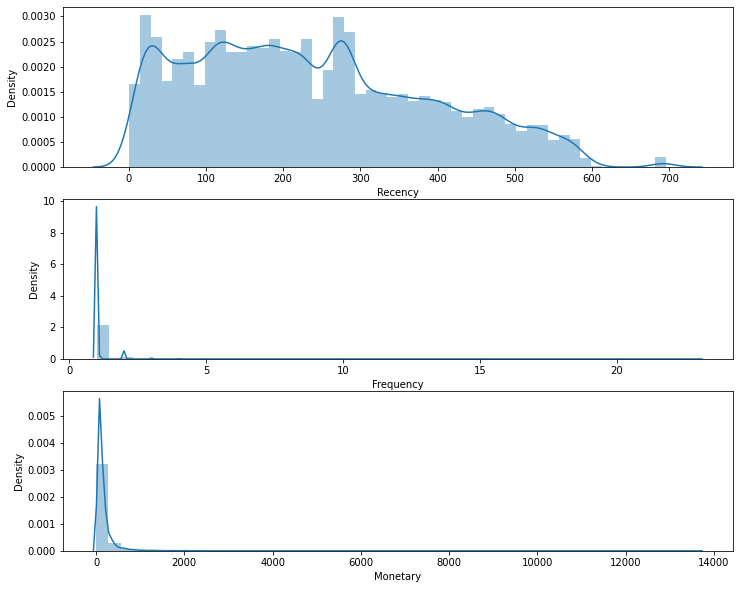

In [51]:
plt.figure(figsize=(12,10))
# Plot distribution of Recency
plt.subplot(3, 1, 1)
sns.distplot(data_process['Recency'])
# Plot distribution of Frequency
plt.subplot(3, 1, 2)
sns.distplot(data_process['Frequency'])
# Plot distribution of Monetary
plt.subplot(3, 1, 3)
sns.distplot(data_process['Monetary'])
# Show the plot
plt.show()

In [52]:
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).values.argmax()
    return series.rank(pct=1).apply(f)

In [53]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 2)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pct_rank_qcut(data_process['Frequency'], 4)
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)

In [54]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['Monetary'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

with these 3 scores in place, R, F, and M, we can create our first RFM segment by concatenating the values together below

In [68]:
#CONCAT RFM QUARTILE VALUES TO CREATE RFM SEGMENT
def join_rfm(x):
    return int(x['R']) + int(x['F']) + int(x['M'])

data_process['RFM_segment'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_segment,RFM_Score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,2,3,9,9
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,2,1,6,6
0000f46a3911fa3c0805444483337064,538,1,86.22,1,2,2,5,5
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,2,1,5,5
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,2,4,8,8


In [69]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_segment')['RFM_segment'].nunique()
print(rfm_count_unique.sum())

9


In [70]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    9
0000b849f77a49e4a4ce2b2a4ca5be3f    6
0000f46a3911fa3c0805444483337064    5
0000f6ccb0745a6a4b88665a16c9f078    5
0004aac84e0df4da2b147fca70cf8255    8
Name: RFM_Score, dtype: int64


### Segmentation using RFM Analysis | Identify Upselling and Cross selling opportunities¶

In [71]:
# Define rfm_level function
def rfm_level(df):
    if (df['RFM_segment'] >= 434 | (df['RFM_Score'] >= 9)) :
        return 'VVIP - Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) & (df['M'] == 4)):
        return 'Champions Big Spenders'
    elif ((df['RFM_Score'] >= 6) & (df['F'] >= 2)):
        return 'Loyal Customers'
    elif ((df['RFM_Score'] <= 4) & (df['R'] == 1)):
        return 'Hibernating Almost Lost'
    elif ((df['RFM_segment'] >= 221) | (df['RFM_Score'] >= 6)):
        return 'Potential Loyalists'
    elif ((df['RFM_segment'] >= 121) & (df['R'] == 1) | (df['RFM_Score'] == 5)):
        return 'Needs Attention'
    else:
        return 'Lost Customers'

In [72]:
# Define rfm marketing action function
def rfm_action(df):
    if (df['RFM_segment'] >= 434 | (df['RFM_Score'] >= 9)) :
        return 'No Price Incentives; Offer Limited edition and Loyality programs'
    elif ((df['RFM_Score'] >= 8) & (df['M'] == 4)):
        return 'Upsell most expensive items'
    elif ((df['RFM_Score'] >= 6) & (df['F'] >= 2)):
        return 'Loyality programs;Cross Sell'
    elif ((df['RFM_Score'] <= 4) & (df['R'] == 1)):
        return 'Aggressive price incentives'
    elif ((df['RFM_segment'] >= 221) | (df['RFM_Score'] >= 6)):
        return 'Cross Sell Recommendations and Discount coupons'
    elif (((df['RFM_segment'] >= 121) & (df['R'] == 1)) | (df['RFM_Score'] == 5)):
        return 'Price incentives and Limited time offer'
    else:
        return 'Don\'t spend too much trying to re-acquire'

In [73]:
# Create a new variable RFM_Level
rfm['RFM_segment'] = rfm.RFM_segment.apply(lambda x:int(x))
rfm['Customer Segment'] = rfm.apply(rfm_level, axis=1)
# Create a new variable RFM_Level
rfm['Marketing Action'] = rfm.apply(rfm_action, axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_segment,RFM_Score,Customer Segment,Marketing Action
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,2,3,9,9,Loyal Customers,Loyality programs;Cross Sell
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,2,1,6,6,Loyal Customers,Loyality programs;Cross Sell
0000f46a3911fa3c0805444483337064,538,1,86.22,1,2,2,5,5,Needs Attention,Price incentives and Limited time offer
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,2,1,5,5,Needs Attention,Price incentives and Limited time offer
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,2,4,8,8,Champions Big Spenders,Upsell most expensive items


In [74]:
rfm['Customer Segment'].value_counts()

Loyal Customers            57065
Champions Big Spenders     17775
Needs Attention            11083
Hibernating Almost Lost     5558
Name: Customer Segment, dtype: int64

### Regrouper les clients par leur segment de clientèle

In [75]:
#Calculate Average values for each customer segment and return size of each segment
rfm_level_agg = rfm.groupby(['Customer Segment']).agg({
        'Recency': 'mean',
        'Frequency' : 'mean',
        'Monetary': ['mean', 'count'],
        'Marketing Action' : 'unique'
}).round(1)
#print the aggregated dataset
print(rfm_level_agg)

                        Recency Frequency Monetary         \
                           mean      mean     mean  count   
Customer Segment                                            
Champions Big Spenders    173.3       1.2    390.3  17775   
Hibernating Almost Lost   454.8       1.0     43.6   5558   
Loyal Customers           212.2       1.1    126.1  57065   
Needs Attention           363.0       1.0     63.8  11083   

                                                  Marketing Action  
                                                            unique  
Customer Segment                                                    
Champions Big Spenders               [Upsell most expensive items]  
Hibernating Almost Lost              [Aggressive price incentives]  
Loyal Customers                     [Loyality programs;Cross Sell]  
Needs Attention          [Price incentives and Limited time offer]  


In [76]:
rfm_level_ag = pd.DataFrame(rfm_level_agg)
rfm_level_ag = rfm_level_ag.reset_index()
rfm_level_ag

Customer Segment Recency Frequency Monetary         \
                              mean      mean     mean  count   
0   Champions Big Spenders   173.3       1.2    390.3  17775   
1  Hibernating Almost Lost   454.8       1.0     43.6   5558   
2          Loyal Customers   212.2       1.1    126.1  57065   
3          Needs Attention   363.0       1.0     63.8  11083   

                            Marketing Action  
                                      unique  
0              [Upsell most expensive items]  
1              [Aggressive price incentives]  
2             [Loyality programs;Cross Sell]  
3  [Price incentives and Limited time offer]

À partir de là, nous pouvons voir qu'un pourcentage suffisant (~ 45 %) de nos clients se situent dans les niveaux RFM les plus élevés. Olist doit faire quelque chose de bien pour maintenir sa loyauté ! Les 55% restants auront besoin de quelques travaux.

1. Loyalistes potentiels - Fort potentiel d'entrer dans nos segments de clients fidèles, pourquoi ne pas ajouter des cadeaux lors de leur prochain achat pour montrer que vous les appréciez !

2. Besoin d'attention - Montre des signes prometteurs avec la quantité et la valeur de leurs achats, mais cela fait un moment qu'ils n'ont pas acheté chez vous. Ciblons-les avec leurs articles de liste de souhaits et une réduction d'offre à durée limitée.

3. Hibernant presque perdu - J'ai fait quelques achats initiaux mais je ne les ai pas revus depuis. Était-ce une mauvaise expérience client ? Ou adéquation produit-marché ? Consacrons quelques ressources à renforcer la notoriété de notre marque avec eux.

4. Clients fidèles - Ce sont les clients les plus fidèles. Ils sont actifs avec des achats fréquents et une valeur monétaire élevée. Ils pourraient être les évangélistes de la marque et devraient se concentrer sur leur bon service. Ils pourraient être les meilleurs clients pour obtenir des commentaires sur les lancements de nouveaux produits ou être les premiers à adopter ou à promouvoir.

5. Champions gros dépensiers - C'est toujours une bonne idée "d'incuber" soigneusement tous les nouveaux clients, mais parce que ces clients ont dépensé beaucoup pour leur achat, c'est encore plus important. Comme pour le groupe des meilleurs clients, il est important de les faire se sentir valorisés et appréciés - et de leur donner de formidables incitations à continuer à interagir avec la marque.

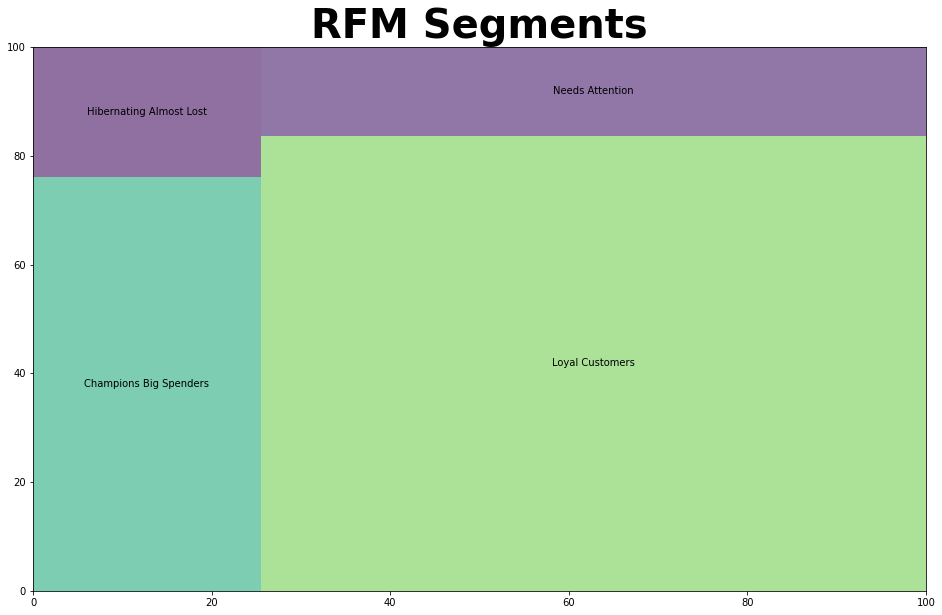

In [77]:
#rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count', 'MarketingAction']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Champions Big Spenders',
                     'Hibernating Almost Lost',
                     'Loyal Customers',
                     'Needs Attention',
                     'Potential Loyalists',
                     'VVIP - Can\'t Loose Them'], alpha=.6 )
plt.title("RFM Segments",fontsize=40,fontweight="bold")
plt.axis('on')
plt.show()

#### Graphique interactif pour visualiser les segments de clientèle

In [78]:
import plotly.graph_objects as go

fig =go.Figure(go.Treemap(
    labels = rfm_level_ag['Customer Segment'],
    parents = ['Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation'],   #rfm_level_ag[('Marketing Action', 'unique')].tolist(), 
    values= rfm_level_ag[('Monetary', 'count')]
))

fig.show()

#### Nous pouvons former nos campagnes marketing et nos stratégies de ciblage sur la base de la segmentation client ci-dessus.
1. Nous pouvons vendre des produits haut de gamme aux grands dépensiers
2. Nous pouvons effectuer des ventes croisées de produits complémentaires aux clients fidèles et aux meilleurs clients

### K-Means Clustering

Nous avons conçu les clusters en fonction du score RFM et des clients segmentés. Maintenant, appliquons une approche d'apprentissage automatique pour identifier s'il y a des segments cachés que nous pouvons trouver à partir des clusters

In [79]:
data_rfm = rfm[['Recency', 'Frequency', 'Monetary']]
data_rfm.min()

Recency      1.00
Frequency    1.00
Monetary     8.86
dtype: float64

In [80]:
import numpy as np
from sklearn.preprocessing import StandardScaler

data_log = np.log(data_rfm)
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data=data_normalized, index=data_rfm.index, columns=data_rfm.columns)

In [81]:
data_normalized.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.463579,-0.236734,0.293602
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.435561,-0.236734,-1.728286
0000f46a3911fa3c0805444483337064,1.199873,-0.236734,-0.316071
0000f6ccb0745a6a4b88665a16c9f078,0.655791,-0.236734,-1.149884
0004aac84e0df4da2b147fca70cf8255,0.541183,-0.236734,0.694392


In [85]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
data_rfm_k5 = data_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k5.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         239.8       2.2    235.7   5297
1         291.1       1.0    142.2  32848
2          41.3       1.0    124.4  14806
3         241.2       1.0    518.2  11394
4         278.2       1.0     52.2  27136

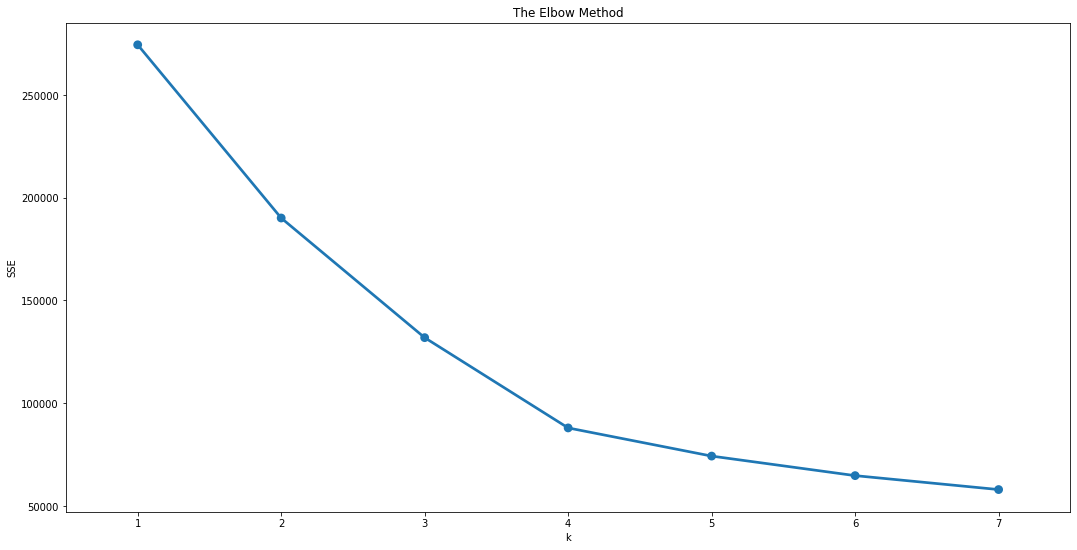

In [86]:
sse = {}
for k in range(1, 8):  
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_
plt.figure(figsize=(18,9))

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [87]:
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
data_rfm_k4 = data_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k4.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         285.6       1.0     68.0  40086
1          42.0       1.0    134.2  15389
2         239.8       2.2    235.7   5297
3         272.6       1.0    294.4  30709

In [88]:
data_melt = pd.melt(
                    data_rfm_k4.reset_index(),               
                    id_vars=['customer_unique_id', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'], 
                    var_name='Metric', value_name='Value'
                    )
data_melt.head(10)

,customer_unique_id,Cluster,Metric,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,3,Recency,112.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,Recency,115.0
2,0000f46a3911fa3c0805444483337064,0,Recency,538.0
3,0000f6ccb0745a6a4b88665a16c9f078,0,Recency,322.0
4,0004aac84e0df4da2b147fca70cf8255,3,Recency,289.0
5,0004bd2a26a76fe21f786e4fbd80607f,3,Recency,147.0
6,00050ab1314c0e55a6ca13cf7181fecf,0,Recency,132.0
7,00053a61a98854899e70ed204dd4bafe,3,Recency,183.0
8,0005e1862207bf6ccc02e4228effd9a0,3,Recency,544.0
9,0005ef4cd20d2893f0d9fbd94d3c0d97,3,Recency,171.0


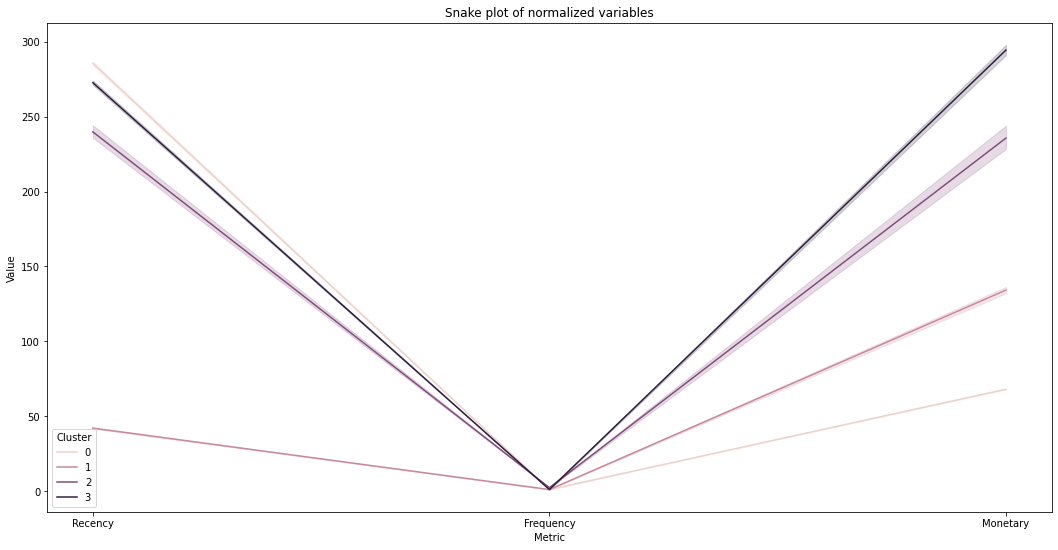

In [89]:
# Snake Plot
plt.figure(figsize = (18,9))
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=data_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

#### Calculer l'importance relative de chaque attribut
Nous allons maintenant calculer l'importance relative des valeurs RFM dans chaque cluster

In [90]:
cluster_avg = data_rfm_k4.groupby(['Cluster']).mean() 
population_avg = data_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,0.20,-0.07,-0.59
1,-0.82,-0.07,-0.19
2,0.01,1.10,0.43
3,0.15,-0.07,0.79


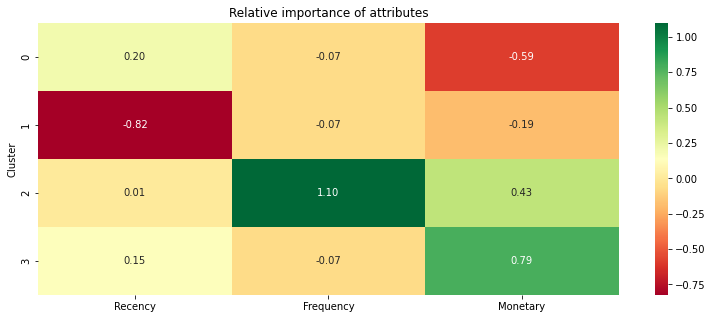

In [91]:
plt.figure(figsize=(13, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()


### Importance relative du RFM parmi les clusters K-Means
Nous pouvons voir que notre résumé groupé de la moyenne de R, F, M que chaque groupe de clients met un accent différent sur nos 4 caractéristiques :

#### Cluster 0
Il a la moyenne de récence la plus basse et la moyenne de fréquence et monétaire équitable. Il fonctionne mal sur R, F et M. nous devrons concevoir des campagnes pour les réactiver.

#### Cluster 1
Ils ont acheté chez nous récemment, mais n'ont pas dépensé autant ou aussi souvent que nous le souhaiterions. Peut-être qu'une certaine personnalisation des produits qui leur sont destinés peut aider à maximiser leur valeur à vie et à revenir acheter ?

#### Cluster 2
Il a une moyenne MontaryValue élevée et une moyenne de récence faible et la moyenne de fréquence la plus élevée - C'est notre segment de clientèle idéal

#### Cluster 3
Il a dépensé pas mal d'argent avec nous mais n'a pas acheté avec nous depuis 3 à 4 mois - Nous devrons faire quelque chose avant de les perdre !